In [46]:
import os
import cv2
import math
from PIL import Image
import xml.etree.ElementTree as ET

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision.ops import nms
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [48]:
data_folder = "/home/student/VOCtrain/VOC2007/"

vehicle_classes = {'aeroplane', 'bicycle', 'boat', 'bus', 'train', 'motorbike'}

image_dim = 800
anchor_scale = torch.FloatTensor([8,16,32])  
anchor_ratio = torch.FloatTensor([0.5,1,2])
conversion_scale = 16


In [49]:
labels = []

for file in os.listdir(data_folder + "Annotations/"):
    xml_tree = ET.parse(data_folder + "Annotations/" + file)
    for obj in xml_tree.findall('object') :
        label = obj.find('name').text
        if label in vehicle_classes:
            labels.append(label)
            
distinct_labels = sorted(set(labels))
num_classes = len(distinct_labels) + 1

label_to_id = {j:i+1 for i,j in enumerate(distinct_labels)}
id_to_label = {i+1:j for i,j in enumerate(distinct_labels)}

In [50]:
class Pascal_Dataset(Dataset):
    
    def __init__(self, path, transform):
        super().__init__()
        self.dir_path = path
        self.transform = transform
        
        self.images = []
        self.annotations = []
        for i in sorted(os.listdir(path + "JPEGImages/")):
            self.images.append(os.path.join(path + "JPEGImages/", i))
        for i in sorted(os.listdir(path + "Annotations/")):
            self.annotations.append(os.path.join(path + "Annotations/", i))
            
        self.labels = []
        self.boxes = []
        files = []
        for i, ann in enumerate(self.annotations):
            xml_tree = ET.parse(ann)
            ll = []
            cs = []
            for obj in xml_tree.findall('object'):
                label = obj.find('name').text
                if label not in vehicle_classes:
                    continue
                label_id = label_to_id[label]
                xmin = int(obj.find('bndbox').find('xmin').text)
                xmax = int(obj.find('bndbox').find('xmax').text)
                ymin = int(obj.find('bndbox').find('ymin').text)
                ymax = int(obj.find('bndbox').find('ymax').text)
                
                if (xmax - xmin) < 10 or (ymax - ymin) < 10:
                    continue
                cs.append([xmin, xmax, ymin, ymax])
                ll.append(label_id)
                
            if(len(ll) == 0):
                continue
                
            self.labels.append(ll)
            self.boxes.append(cs)
            files.append(self.images[i])
            
        self.images = files
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        image = Image.open(image_name)
            
        box = np.array(self.boxes[idx])
        label = self.labels[idx]
        
        img_h_pre = image.size[1]
        img_w_pre = image.size[0]
        if self.transform:
            image = self.transform(image)
        img_h_post = image.shape[1]
        img_w_post = image.shape[2]
        
        height_ratio = img_h_post/img_h_pre
        width_ratio = img_w_post/img_w_pre
                
        box[:,0] = box[:,0]*width_ratio
        box[:,1] = box[:,1]*width_ratio
        box[:,2] = box[:,2]*height_ratio
        box[:,3] = box[:,3]*height_ratio
        boxes = (box).tolist()   
        
        return image, boxes, label             

In [51]:
# https://github.com/lucidrains/vit-pytorch/issues/159

inference_transform = transforms.Compose(
    [
        transforms.Resize((image_dim, image_dim)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

dataset = Pascal_Dataset(data_folder, inference_transform)
loader = DataLoader(dataset, batch_size=1)

In [52]:
def display_image(image, boxes, image_name=''):
    plt.figure(figsize=(5,5))
    actual_image = normalize(image[0]).permute(1,2,0).to('cpu').numpy().copy()
    for box in boxes:
        x0, x1, y0, y1 = box
        cv2.rectangle(actual_image, (int(x0), int(y0)), (int(x1), int(y1)), color=(0, 255, 255), thickness=2)
    if image_name == '':
        plt.imshow(actual_image)
        plt.show()  
    else:
        plt.imshow(actual_image)
        plt.savefig(image_name + '.png')

In [53]:
# Reference - https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3

# Generate anchor for point
def gen_anchor_for_pt(x, y):
    anchor_boxes = torch.zeros((len(anchor_scale) * len(anchor_ratio),4))
    x_center = (x*2+1)*(conversion_scale/2) 
    y_center = (y*2+1)*(conversion_scale/2)
    for ratio_idx, ratio in enumerate(anchor_ratio):
        for scale_idx, scale in enumerate(anchor_scale):
            i = len(anchor_scale)*ratio_idx + scale_idx
            h = conversion_scale*scale*torch.sqrt(ratio)
            w = conversion_scale*scale*torch.sqrt(1.0/ratio)
            
            anchor_boxes[i,0] = x_center - w/2
            anchor_boxes[i,1] = x_center + w/2
            anchor_boxes[i,2] = y_center - h/2
            anchor_boxes[i,3] = y_center + h/2
            
    return anchor_boxes

# Generate anchors for entire image 
def gen_anchors(width, height):
    anchor_boxes = torch.zeros((width*height, len(anchor_scale) * len(anchor_ratio), 4))
    for x_center in range(width):
        for y_center in range(height):
            i = x_center*height + y_center
            anchors = gen_anchor_for_pt(x_center, y_center)
            anchor_boxes[i] = anchors
    return anchor_boxes.reshape(-1,4)

# Remove anchor outside image boundings
def get_valid_anchors(anchor_boxes):
    valid_anchors = torch.where((anchor_boxes[:,0] >= 0) & 
             (anchor_boxes[:,1] <= image_dim) &
             (anchor_boxes[:,2] >= 0) &
             (anchor_boxes[:,3] <= image_dim))[0]

    anchor_boxes = anchor_boxes[valid_anchors]
    return anchor_boxes, valid_anchors
    
                                


In [54]:
# Get Intersection over Union between all the boxes in valid vs ground truth boxes
def get_iou(valid_boxes, gt_boxes):
    iou_matrix = torch.zeros((len(valid_boxes), len(gt_boxes)))
    for i , gt_box in enumerate(gt_boxes):
        if isinstance(gt_box,torch.Tensor):
            gt = torch.cat([gt_box]*len(valid_boxes)).view(1,-1,4)[0]
        else:
            gt = torch.FloatTensor([gt_box]*len(valid_boxes))
        xmax = torch.max(gt[:,0],valid_boxes[:,0])
        xmin = torch.min(gt[:,1],valid_boxes[:,1])
        ymax = torch.max(gt[:,2],valid_boxes[:,2])
        ymin = torch.min(gt[:,3],valid_boxes[:,3])
                
        invalid_roi = (xmin < xmax) | (ymin < ymax)
        roi_area = (xmin - xmax)*(ymin - ymax)
        roi_area[invalid_roi] = 0
        
        total_area = (gt[:,1] - gt[:,0])*(gt[:,3] - gt[:,2]) + \
        (valid_boxes[:,1] - valid_boxes[:,0])*(valid_boxes[:,3]-valid_boxes[:,2]) - roi_area
                    
        iou = roi_area/(total_area + 1e-6)     
        iou_matrix[:,i] = iou
    return iou_matrix
        

def get_max_iou(iou_matrix):
    gt_max_value = iou_matrix.max(axis=0)[0]
    all_gt_max = torch.where(iou_matrix == gt_max_value)[0]
    
    anchor_max_value = torch.max(iou_matrix, axis=1)[0]
    anchor_max = torch.argmax(iou_matrix, axis=1)
    
    return all_gt_max, anchor_max_value, anchor_max



# positive - 1, negative - 0, ignore - -1
def get_anchor_labels(anchor_boxes, all_gt_max, anchor_max_value):
    anchor_labels = torch.zeros(anchor_boxes.shape[0])
    anchor_labels.fill_(-1.0)
    anchor_labels[anchor_max_value < 0.3] = 0
    anchor_labels[all_gt_max] = 1.0
    anchor_labels[anchor_max_value > 0.7] = 1.0
    return anchor_labels


def sample_anchors_for_train(anchor_labels):
    sample_size = 256
    pos_anchor = torch.where(anchor_labels == 1)[0]
    num_pos = int(min(sample_size/2, len(pos_anchor)))
    pos_idx = np.random.choice(pos_anchor,  num_pos, replace=False)

    neg_anchor = torch.where(anchor_labels == 0)[0]
    num_neg = sample_size - num_pos
    neg_idx = np.random.choice(neg_anchor, int(num_neg), replace=False)
    
    anchor_labels[:] = -1
    anchor_labels[pos_idx] = 1
    anchor_labels[neg_idx] = 0
    
    return anchor_labels

In [55]:
def anchor_gt(anchor_boxes, gt_boxes, anchor_max):
    max_iou_bbox =  gt_boxes[anchor_max]
    
    anchor_width =  anchor_boxes[:,1] - anchor_boxes[:,0]
    anchor_height = anchor_boxes[:,3] - anchor_boxes[:,2]
    anchor_xctr = anchor_boxes[:,0] + anchor_width/2
    anchor_yctr = anchor_boxes[:,2] + anchor_height/2
    
    gt_width =  max_iou_bbox[:,1] - max_iou_bbox[:,0]
    gt_height = max_iou_bbox[:,3] - max_iou_bbox[:,2]
    gt_xctr = max_iou_bbox[:,0] + gt_width/2
    gt_yctr = max_iou_bbox[:,2] + gt_height/2
    
    result = torch.zeros_like(anchor_boxes)
    result[:,0] = (gt_xctr - anchor_xctr)/anchor_width
    result[:,1] = (gt_yctr - anchor_yctr)/anchor_height
    result[:,2] = torch.log(gt_width/anchor_width)
    result[:,3] = torch.log(gt_height/anchor_height)
   
    return result

def correct_anchors(anchor_boxes, t):
    anchor_w =  anchor_boxes[:,1] - anchor_boxes[:,0]
    anchor_h = anchor_boxes[:,3] - anchor_boxes[:,2]
    anchor_x = anchor_boxes[:,0] + anchor_w/2
    anchor_y = anchor_boxes[:,2] + anchor_h/2

    x = t[:,0]*anchor_w + anchor_x
    y = t[:,1]*anchor_h + anchor_y
    w = torch.exp(t[:,2])*anchor_w
    h = torch.exp(t[:,3])*anchor_h
    
    correct_anchor = torch.zeros_like(anchor_boxes)
    
    correct_anchor[:,0] = x - w/2
    correct_anchor[:,1] = x + w/2
    correct_anchor[:,2] = y - h/2
    correct_anchor[:,3] = y + h/2
    
    return correct_anchor

In [56]:
def non_max_suppression(anchor_boxes, class_score, img_h, img_w, is_train):
    
    if is_train:
        nms_pre = 12000
        nms_post = 2000
    else:
        nms_pre = 6000
        nms_post = 300
        
    anchor_boxes[anchor_boxes[:,0] < 0, 0] = 0
    anchor_boxes[anchor_boxes[:,1] > img_w, 1] = img_w
    anchor_boxes[anchor_boxes[:,2] < 0, 2] = 0 
    anchor_boxes[anchor_boxes[:,3] > img_h, 3] = img_h

    anchor_width = anchor_boxes[:,1] - anchor_boxes[:,0]
    anchor_height = anchor_boxes[:,3] - anchor_boxes[:,2]
    
    # Remove anchors boxes small than min dimensions 16, 16
    legal_idx = (anchor_height > 16) & (anchor_width > 16)
    anchor_boxes = anchor_boxes[legal_idx]
    class_score = class_score[legal_idx]
    
    # Get top nms_pre boxes
    sorted_class_scores = torch.argsort(class_score, descending=True)
    top_nms_idx = sorted_class_scores[:nms_pre]
    anchor_boxes = anchor_boxes[top_nms_idx]
    class_score = class_score[top_nms_idx]
    
    # nms function expects (x1, y1, x2, y2)
    cloned_boxes = torch.zeros_like(anchor_boxes)
    cloned_boxes[:,0] = anchor_boxes[:,0]
    cloned_boxes[:,1] = anchor_boxes[:,2]
    cloned_boxes[:,2] = anchor_boxes[:,1]
    cloned_boxes[:,3] = anchor_boxes[:,3]
    
    anchor_idx = nms(cloned_boxes.to('cpu'), class_score.clone().detach().to('cpu'), 0.7)[:nms_post]
    anchor_boxes = anchor_boxes[anchor_idx]   
    return anchor_boxes

    

In [57]:
def classify_anchors(roi, gt_boxes, gt_labels, is_train):
    num_sample = 128  #Number of samples to sample from roi

    iou = get_iou(roi, gt_boxes)
    roi_argmax = iou.argmax(axis=1)
    roi_max = iou.max(axis=1)[0]
    assign_labels = gt_labels[roi_argmax]
    
    num_pos = num_sample*0.25
    pos_idx = torch.where(roi_max > 0.5)[0]
    if is_train:
        pos_idx = np.random.choice(pos_idx, int(min(len(pos_idx), num_pos)), replace=False)  
    num_neg = num_sample-len(pos_idx)
    neg_idx = torch.where(roi_max < 0.5)[0]
    if is_train:
        neg_idx = np.random.choice(neg_idx, int(min(len(neg_idx), num_neg)), replace=False)
        
    final_idx = np.append(pos_idx, neg_idx)
    assign_labels[neg_idx] = 0
    assign_labels = assign_labels[final_idx]
    roi = roi[final_idx]
    roi_argmax = roi_argmax[final_idx]
    return assign_labels, roi, roi_argmax, final_idx

In [58]:
def roi_pooling(roi, features):
    layer = nn.AdaptiveMaxPool2d((7,7)).to(device)
    roi = roi/16.0
    result = []
    for i in roi:
        x1 = int(i[0])
        x2 = int(i[1]+1)
        y1 = int(i[2])
        y2 = int(i[3]+1)
        result.append(layer(features[:,:,y1:y2,x1:x2]))
    result = torch.cat(result)
    return result

In [59]:
def VGG_Backbone(): 
    vgg = models.vgg16(weights='IMAGENET1K_V1')
    vgg_features  = vgg.features[:-1]
    vgg_classifier = vgg.classifier[:-1]
    
    for layer in vgg_features[:10]:
        for param in layer.parameters():
            param.requires_grad = False
    
    return vgg_features.to(device), vgg_classifier.to(device)

class FastRCNN(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.flatten = nn.Flatten()
        self.backbone = backbone
        self.classify = nn.Linear(4096, num_classes)
        self.reg = nn.Linear(4096, num_classes*4)
        
    def forward(self, x):
        x = self.backbone(self.flatten(x))
        pred_class = self.classify(x)
        pred_box = self.reg(x)
        return pred_class, pred_box

In [60]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, backbone, in_features=512, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        self.backbone = backbone
        self.conv = nn.Conv2d(in_features, hidden_dim, 3, 1, 1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, 2*len(anchor_scale)*len(anchor_ratio), 1, 1, 0)
        self.reg_head = nn.Conv2d(hidden_dim, 4*len(anchor_scale)*len(anchor_ratio), 1 ,1 , 0)
        
        self.conv.bias.data.zero_()
        self.conv.weight.data.normal_(0, 0.01)
        self.conf_head.bias.data.zero_()
        self.conf_head.weight.data.normal_(0, 0.01)
        self.reg_head.bias.data.zero_()
        self.reg_head.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        features = self.backbone(x)
        conv_out = F.relu(self.dropout(self.conv(features)))
        conf = self.conf_head(conv_out)
        reg = self.reg_head(conv_out)
        return features, conf, reg

def region_prop_loss(pred_box, pred_class, gt_box, gt_class):
    gt_box = gt_box.to(device)
    gt_class = gt_class.long().to(device)
    
    foreground_class_idx = (gt_class > 0)
    pred_box = pred_box[foreground_class_idx]
    gt_box = gt_box[foreground_class_idx]
    reg_loss = F.smooth_l1_loss(pred_box, gt_box) / (sum(foreground_class_idx)+1e-6)
    class_loss = F.cross_entropy(pred_class, gt_class, ignore_index=-1)
    return reg_loss + class_loss

In [61]:
feature_extracter, classifier = VGG_Backbone()
rpn = RegionProposalNetwork(feature_extracter).to(device)
fast_rcnn = FastRCNN(classifier).to(device)
all_params = list(list(rpn.parameters()) + list(fast_rcnn.parameters()))
optimizer = optim.Adam(all_params, lr=0.00005)

In [62]:
all_anchors = gen_anchors(int(image_dim/conversion_scale), int(image_dim/conversion_scale)).to(device)

def train_image(input_image, gt_box, label, is_train):

    input_image = input_image.to(device)
    gt_box = torch.FloatTensor(gt_box).to(device)
    label = torch.FloatTensor(label).to(device)

    valid_anchors, valid_anchors_idx = get_valid_anchors(all_anchors.clone())
    iou = get_iou(valid_anchors, gt_box)
    all_gt_max, anchor_max_value, anchor_max = get_max_iou(iou)
    
    anchor_labels = get_anchor_labels(valid_anchors, all_gt_max, anchor_max_value)
    anchor_labels = sample_anchors_for_train(anchor_labels)
    
    delta = anchor_gt(valid_anchors, gt_box, anchor_max)
    gt_boxes = torch.zeros_like(all_anchors)
    gt_boxes[valid_anchors_idx] = delta

    gt_class = torch.zeros(all_anchors.shape[0])
    gt_class.fill_(-1)
    gt_class[valid_anchors_idx] = anchor_labels
    
    features, class_out, pred_box = rpn(input_image)

    pred_class = class_out.permute(0,2,3,1).reshape(1,-1,2)[0]
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()
    pred_box = pred_box.permute(0,2,3,1).reshape(1,-1,4)[0]

    rpn_loss = region_prop_loss(pred_box, pred_class, gt_boxes, gt_class).to(device)    
    corrected_anchors = correct_anchors(all_anchors.to(device), pred_box).detach()
    
    roi = non_max_suppression(corrected_anchors, class_score, input_image.shape[2], input_image.shape[3], is_train)
    
    assign_labels, roi_samples, roi_argmax, idx = classify_anchors(roi, gt_box, label, is_train)
    decider_box = anchor_gt(roi_samples, gt_box, roi_argmax)
   
    pooled_features = roi_pooling(roi_samples, features)

    final_class, final_box = fast_rcnn(pooled_features)
    final_box = final_box.reshape(pooled_features.shape[0],-1,4)
    final_box = final_box[torch.arange(0,pooled_features.shape[0]), assign_labels.long()]
    
    rcnn_loss = region_prop_loss(final_box, final_class, decider_box, assign_labels).to(device)
    
    with torch.no_grad():
        final_box_no_grad = final_box.clone().to(device)

    corrected_roi = correct_anchors(roi_samples, final_box_no_grad).detach()    
    return rpn_loss, rcnn_loss , final_class, corrected_roi

In [63]:
def test_model(input_image):
    input_image = input_image.to(device)
    rpn.eval()
    fast_rcnn.eval()
    
    features, class_out, pred_box = rpn(input_image)
    pred_box = pred_box.permute(0,2,3,1).reshape(1,-1,4)[0]
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()

    corrected_anchors = correct_anchors(all_anchors.to(device), pred_box).detach()
    roi = non_max_suppression(corrected_anchors, class_score, input_image.shape[2],input_image.shape[3], False)
    pooled_features = roi_pooling(roi, features)

    final_class, final_box = fast_rcnn(pooled_features)
    with torch.no_grad():
        final_box_no_grad = final_box.clone().to(device)
    corrected_roi = correct_anchors(roi, final_box_no_grad).detach()

    final_conf = final_class.softmax(dim=1).max(dim=1)[0]
    final_conf = final_conf.detach()
    final_conf = final_conf[final_class.argmax(axis=1) != 0]
    sorted_class_scores = torch.argsort(final_conf, descending=True)

    anchors = []
    while len(sorted_class_scores) > 1:
        current = sorted_class_scores[0]
        anchors.append(current.item())
        iou = get_iou(corrected_roi[sorted_class_scores[1:]],corrected_roi[current].reshape(1,-1,4)[0])
        sorted_class_scores = sorted_class_scores[np.where(iou < 0.2)[0] + 1]

    if (len(sorted_class_scores) == 1):
        anchors.append(sorted_class_scores[0].item())

    for pred in final_class.argmax(axis=1)[final_class.argmax(axis=1) != 0][anchors]:
        print(id_to_label[int(pred)], end=', ')
    print('')

    for pred in final_conf[anchors]:
        print(pred.item(), end=', ')

    display_image(input_image, roi[final_class.argmax(axis=1) != 0][anchors])

In [64]:
epochs = 6
counter = 0
print_net_loss = 0
print_step = 500

for epoch in range(epochs):
    print("Starting epoch " + str(epoch))
    for i, data in enumerate(loader, 0):
        img, gt_box, labels = data
        loss1, loss2, pred_class, pred_box = train_image(img.to(device), gt_box, labels, True)
        net_loss = loss1 + loss2

        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()

        net_loss = net_loss.detach()
        if not(math.isnan(net_loss)):
            counter += 1
            print_net_loss += net_loss.data
            if (counter % print_step == 0):
                print("Average loss for " + str(counter) + " training images = " + str(print_net_loss/counter))
                counter = 0
                print_net_loss = 0


Starting epoch 0
Average loss for 500 training images = tensor(0.6206, device='cuda:0')
Average loss for 500 training images = tensor(0.4388, device='cuda:0')
Starting epoch 1
Average loss for 500 training images = tensor(0.4209, device='cuda:0')
Average loss for 500 training images = tensor(0.3502, device='cuda:0')
Average loss for 500 training images = tensor(0.3249, device='cuda:0')
Starting epoch 2
Average loss for 500 training images = tensor(0.3149, device='cuda:0')
Average loss for 500 training images = tensor(0.2808, device='cuda:0')
Starting epoch 3
Average loss for 500 training images = tensor(0.2819, device='cuda:0')
Average loss for 500 training images = tensor(0.2532, device='cuda:0')
Average loss for 500 training images = tensor(0.2462, device='cuda:0')
Starting epoch 4
Average loss for 500 training images = tensor(0.2277, device='cuda:0')
Average loss for 500 training images = tensor(0.2073, device='cuda:0')
Starting epoch 5
Average loss for 500 training images = tensor(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


motorbike, motorbike, motorbike, 
0.8908259868621826, 0.7889049053192139, 0.6984686255455017, 

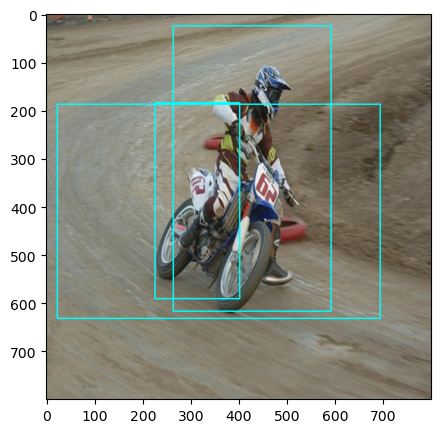

In [65]:
img = Image.open('/home/student/006585.jpg')
img = inference_transform(img).unsqueeze(0)
test_model(img)

In [69]:
fast_rcnn

FastRCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classify): Linear(in_features=4096, out_features=7, bias=True)
  (reg): Linear(in_features=4096, out_features=28, bias=True)
)